In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

file_path = '7_results.csv'

if not os.path.exists(file_path):
    print(f"Ошибка: Файл {file_path} не найден.")
    exit()

df = pd.read_csv(file_path)

scenarios = df['Scenario'].unique()
Methods = df['Method'].unique()

# Базовое время берется от Blocking режима на 1 процессе для каждого сценария
base_times = {}
for scen in scenarios:
    row = df[(df['Scenario'] == scen) & (df['Method'] == 'Blocking') & (df['Processes'] == 1)]
    if not row.empty:
        base_times[scen] = row['Time_s'].values[0]

def get_t1(row):
    return base_times.get(row['Scenario'], np.nan)

df['T_1'] = df.apply(get_t1, axis=1)
df['Speedup'] = df['T_1'] / df['Time_s']
df['Efficiency'] = df['Speedup'] / df['Processes']

scenarios = sorted(scenarios)

df.head()

,Scenario,Method,Nodes,Processes,TotalWork,MsgBytes,Time_s,T_1,Speedup,Efficiency
0,ComputeHeavy,Blocking,1,1,1000000000,1,52.203700,52.203700,1.000000,1.000000
1,ComputeHeavy,NonBlocking,1,1,1000000000,1,51.795000,52.203700,1.007891,1.007891
2,LatencyBound,Blocking,1,1,10000000,100,0.568632,0.568632,1.000000,1.000000
3,LatencyBound,NonBlocking,1,1,10000000,100,0.563588,0.568632,1.008950,1.008950
4,BandwidthBound,Blocking,1,1,10000000,1048576,0.576177,0.576177,1.000000,1.000000


Execution Time


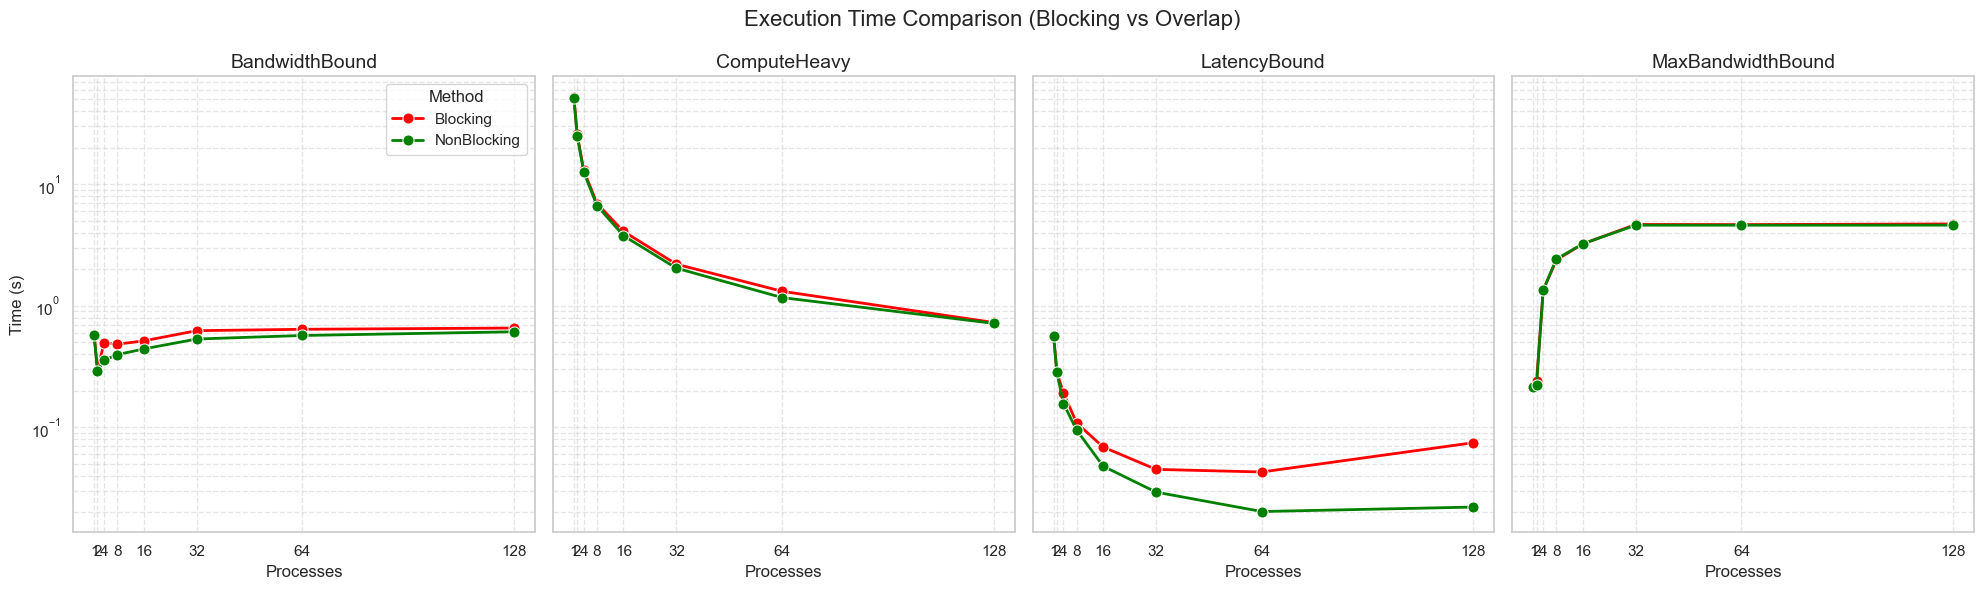

Speedup


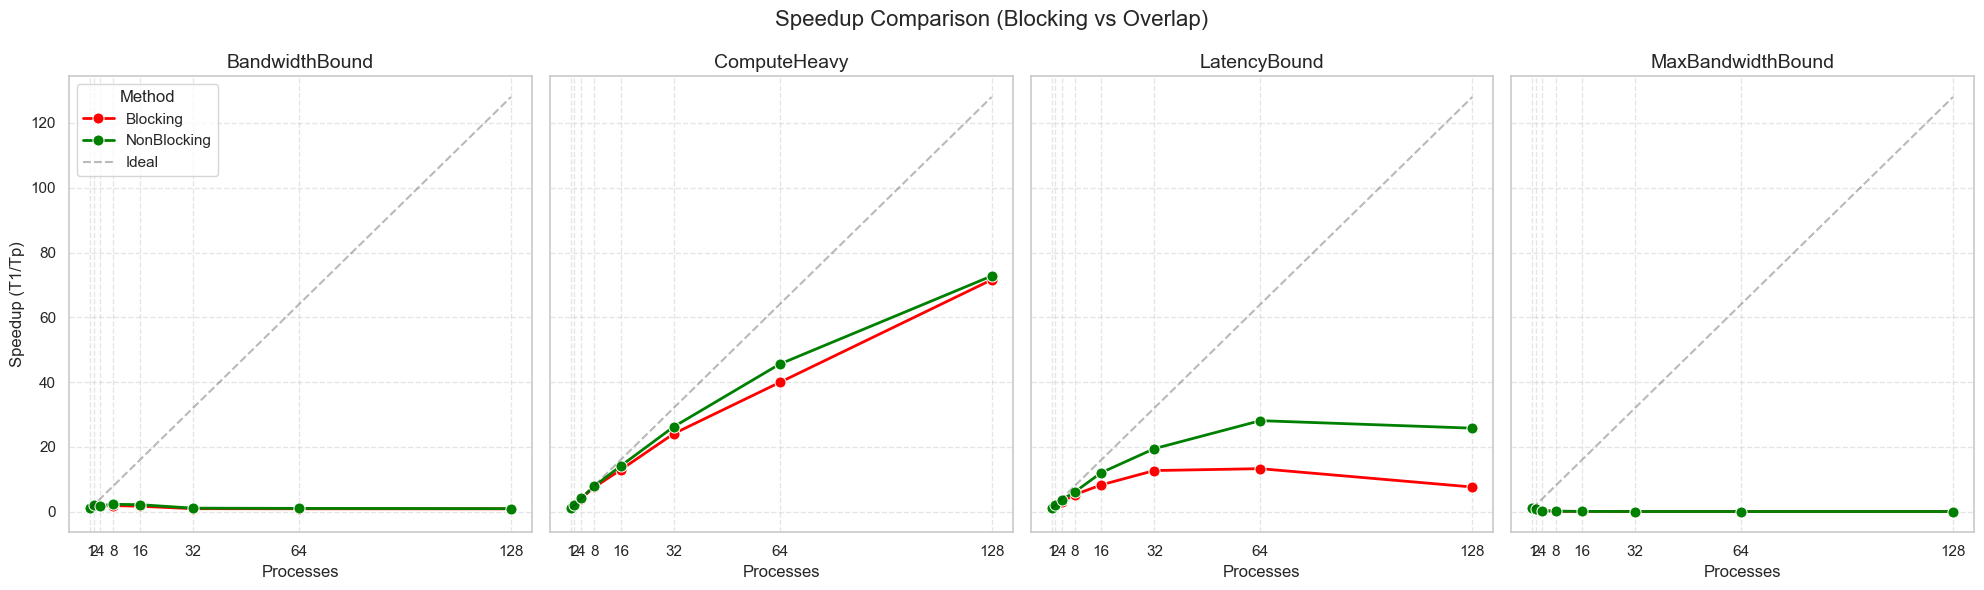

Efficiency


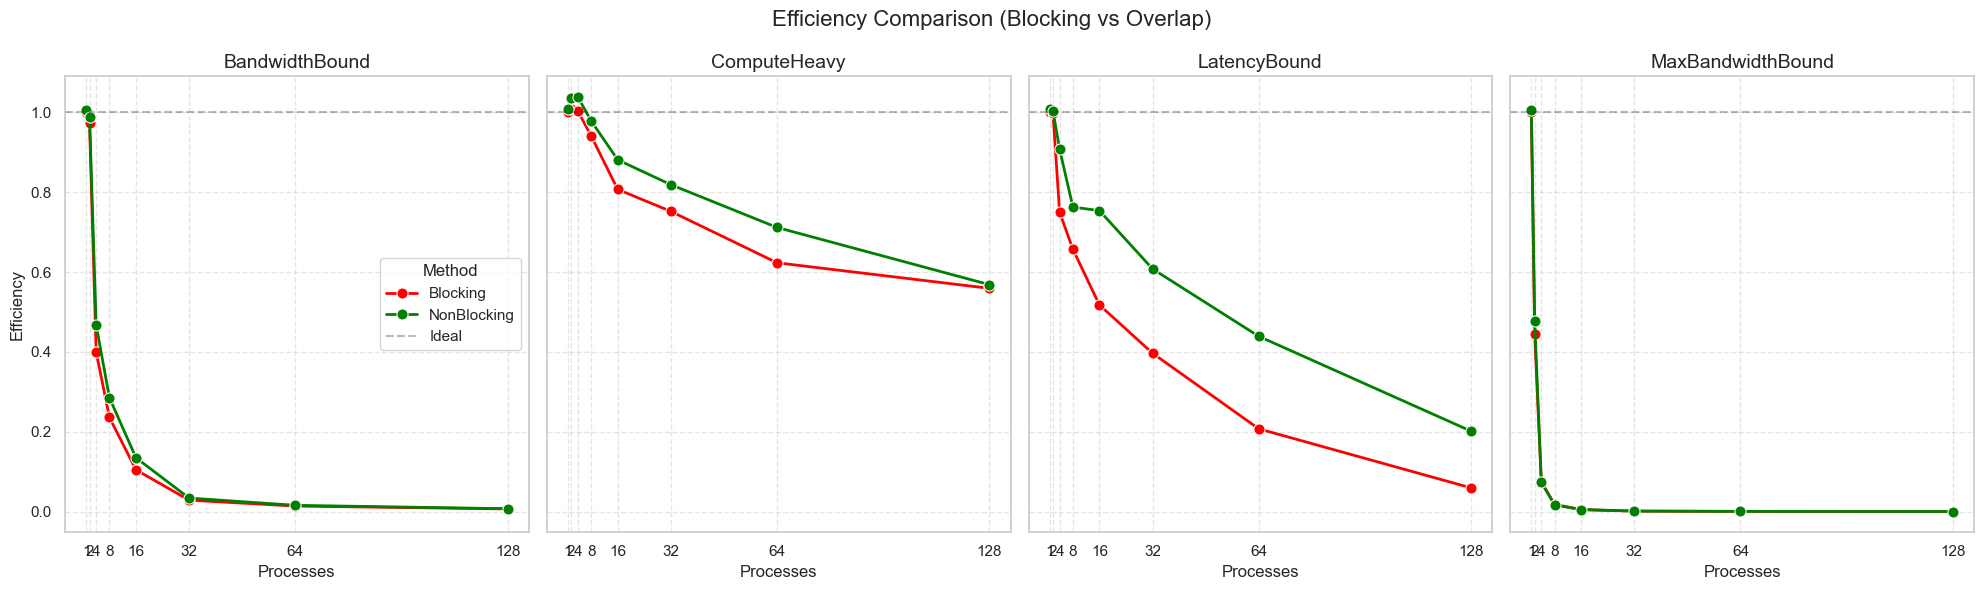

In [19]:
sns.set_theme(style="whitegrid")

def plot_comparison(y_col, title, ylabel, log_y=False):
    print(title)
    num_plots = len(scenarios)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]

    for i, scen in enumerate(scenarios):
        ax = axes[i]
        subset = df[df['Scenario'] == scen].sort_values(by='Processes')

        sns.lineplot(data=subset, x='Processes', y=y_col, 
                     hue='Method', 
                     style='Method',
                     errorbar=None,
                     marker='o', dashes=False, markersize=8, linewidth=2,
                     palette={'Blocking': 'red', 'NonBlocking': 'green'}, 
                     ax=ax)
        
        if y_col == 'Speedup':
            max_p = subset['Processes'].max()
            ax.plot([1, max_p], [1, max_p], 'k--', alpha=0.3, label='Ideal')
        elif y_col == 'Efficiency':
            ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3, label='Ideal')

        ax.set_title(f'{scen}', fontsize=14)
        ax.set_xlabel('Processes', fontsize=12)
        if i == 0:
            ax.set_ylabel(ylabel, fontsize=12)

        if log_y:
            ax.set_yscale('log')
        
        ax.set_xticks(sorted(subset['Processes'].unique()))
        ax.grid(True, which="both", ls="--", alpha=0.5)
        
        if i == 0:
            ax.legend(title='Method', loc='best')
        else:
            if ax.get_legend(): ax.get_legend().remove()

    plt.suptitle(f'{title} Comparison (Blocking vs Overlap)', fontsize=16)
    plt.tight_layout()
    plt.show()


plot_comparison('Time_s', 'Execution Time', 'Time (s)', log_y=True)
plot_comparison('Speedup', 'Speedup', 'Speedup (T1/Tp)')
plot_comparison('Efficiency', 'Efficiency', 'Efficiency')